In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import unicodedata
import numpy as np


In [2]:
# # Define paths for input and output folder
# input_folder = 'data/rawData'
# output_folder = 'data/preprocessedData'
# Define directories
raw_data_dir = 'data/rawData'
preprocessed_dir = 'data/preprocessedData'
augmented_dir = 'data/augmentedData'

Displaying first few images

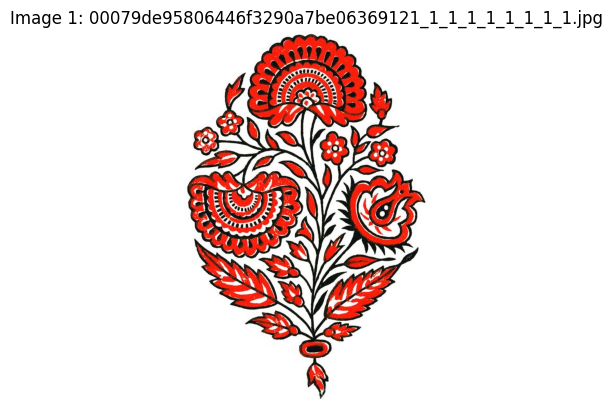

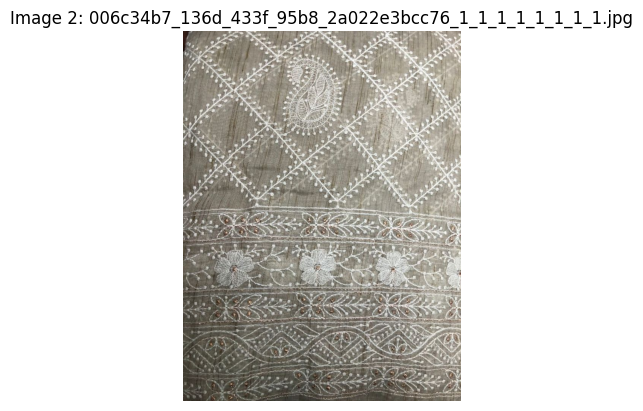

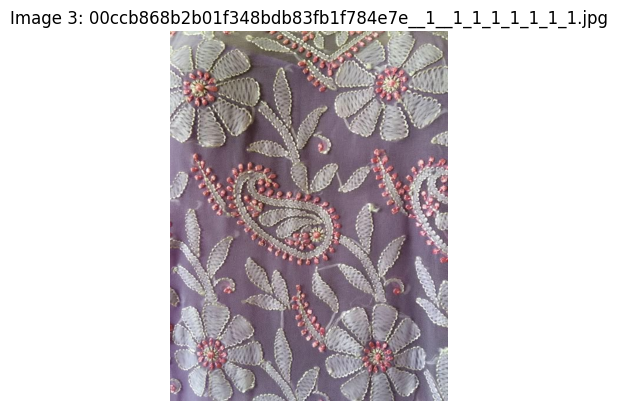

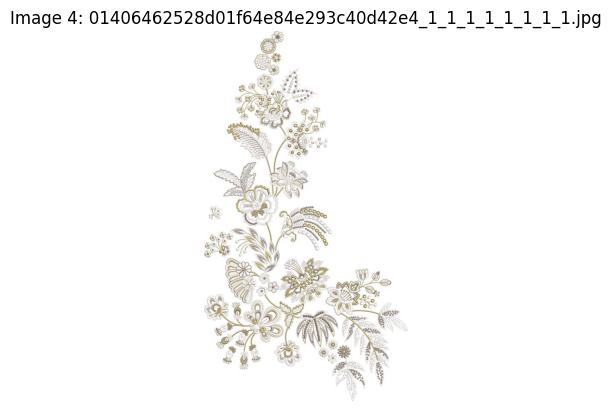

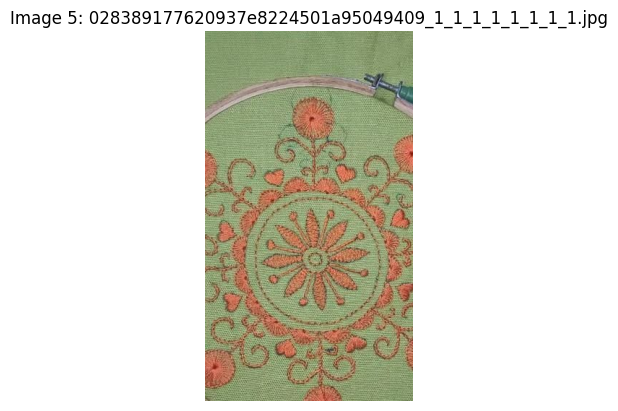

In [4]:
files = os.listdir(raw_data_dir)

# Filter for common image file extensions
image_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in files if f.lower().endswith(image_extensions)]

# Sort the image files to ensure consistent order
image_files.sort()

# Display the first few images
num_images_to_display = 5
for i, image_file in enumerate(image_files[:num_images_to_display]):
    image_path = os.path.join(raw_data_dir, image_file)
    try:
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.title(f'Image {i+1}: {image_file}')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error opening {image_file}: {e}")


## Pre-processing

In [5]:
# Create necessary directories
os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Step 1: Rename files to a standardized format
def rename_files(directory):
    existing_filenames = set()
    for filename in os.listdir(directory):
        # Normalize the filename to ASCII
        normalized_filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore').decode('ascii')
        # Replace spaces with underscores and remove special characters
        sanitized_filename = ''.join(c if c.isalnum() or c in (' ', '.', '_') else '_' for c in normalized_filename)
        sanitized_filename = sanitized_filename.replace(' ', '_')
        # Ensure the filename is unique within the directory
        original_sanitized_filename = sanitized_filename
        counter = 1
        while sanitized_filename in existing_filenames or os.path.exists(os.path.join(directory, sanitized_filename)):
            name, ext = os.path.splitext(original_sanitized_filename)
            sanitized_filename = f"{name}_{counter}{ext}"
            counter += 1
        existing_filenames.add(sanitized_filename)
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, sanitized_filename)
        os.rename(old_path, new_path)
        # print(f'Renamed: {old_path} -> {new_path}')

In [6]:
# Step 2: Preprocess images (resize, denoise, normalize)
def preprocess_images(input_dir, output_dir):
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize to 256x256
                img_resized = cv2.resize(img, (256, 256))
                # Apply Gaussian blur
                img_denoised = cv2.GaussianBlur(img_resized, (5, 5), 0)
                # Normalize to [-1, 1]
                img_normalized = (img_denoised.astype(np.float32) / 127.5) - 1.0
                # Save preprocessed image
                save_path = os.path.join(output_dir, filename)
                # Convert back to [0, 255] for saving
                img_to_save = ((img_normalized + 1.0) * 127.5).astype(np.uint8)
                cv2.imwrite(save_path, img_to_save)
                

In [7]:
# Step 3: Data augmentation
def augment_images(input_dir, output_dir):
    def rotate_image(image, angle):
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, M, (w, h))

    def flip_image(image, direction):
        return cv2.flip(image, direction)

    def adjust_brightness(image, factor):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv = np.array(hsv, dtype=np.float64)
        hsv[:, :, 2] = hsv[:, :, 2] * factor
        hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
        hsv = np.array(hsv, dtype=np.uint8)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    def add_gaussian_noise(image, mean=0, std=10):
        gauss = np.random.normal(mean, std, image.shape).astype('uint8')
        noisy = cv2.add(image, gauss)
        return noisy

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_dir, filename)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Unable to load image {img_path}. Skipping.")
                continue
            base_name, ext = os.path.splitext(filename)
            # Save original image
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_original{ext}"), image)
            # Apply rotation
            for angle in [90, 180, 270]:
                rotated = rotate_image(image, angle)
                cv2.imwrite(os.path.join(output_dir, f"{base_name}_rotated_{angle}{ext}"), rotated)
            # Apply flipping
            flipped_h = flip_image(image, 1)
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_flipped_h{ext}"), flipped_h)
            flipped_v = flip_image(image, 0)
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_flipped_v{ext}"), flipped_v)
            # Adjust brightness
            for factor in [0.5, 1.5]:
                bright = adjust_brightness(image, factor)
                cv2.imwrite(os.path.join(output_dir, f"{base_name}_brightness_{factor}{ext}"), bright)
            # Add Gaussian noise
            noisy = add_gaussian_noise(image)
            cv2.imwrite(os.path.join(output_dir, f"{base_name}_noisy{ext}"), noisy)
            # print(f"Augmented images for {filename} saved.")

# Execute preprocessing steps
rename_files(raw_data_dir)
preprocess_images(raw_data_dir, preprocessed_dir)
augment_images(preprocessed_dir, augmented_dir)

Creating Data Loader

In [22]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to the dataset
dataset_path = 'data/augmentedData'

# Ensure there's at least one subdirectory
if not any(os.path.isdir(os.path.join(dataset_path, d)) for d in os.listdir(dataset_path)):
    # Create a subdirectory and move all images into it
    os.makedirs(os.path.join(dataset_path, 'unspecified'), exist_ok=True)
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            os.rename(file_path, os.path.join(dataset_path, 'unspecified', file))

# Define transformations
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
# ])
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),  # Resize images to 64x64
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] if using Tanh activation
# ])
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader with shuffling
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)



In [23]:
import torch

dummy_input = torch.randn(1, 3, 64, 64)  # Adjust the size if your input images are different
conv_output = encoder.conv(dummy_input)
print(conv_output.shape)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [24]:
flattened_size = 512 * 4 * 4

MODEL ARCHITECTURE

VAE ENCODER

In [25]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # Output: 64x32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),  # Output: 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


VAE DECODER

In [26]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, flattened_size)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # Output: 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # Output: 3x64x64
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)
        return x


Discriminator

In [32]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(3, 64, 4, 2, 1),  # Output: 64x32x32
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128x16x16
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(128, 256, 4, 2, 1),  # Output: 256x8x8
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(256, 512, 4, 2, 1),  # Output: 512x4x4
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(512, 1, 4, 1, 0),  # Output: 1x1x1
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.main(x).view(-1, 1).squeeze(1)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # Output: 64x32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # Output: 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # Output: 256x8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),  # Output: 512x4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),  # Output: 1x1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)  # Ensure a single tensor is returned



In [33]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100

# Instantiate model classes
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator().to(device)

VAE LOSS

In [34]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


GAN LOSS

In [35]:
adversarial_loss = nn.BCELoss()


Training Loop

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import os
import time

# Assuming encoder, decoder, discriminator, dataloader, and device are already defined

# Hyperparameters
# latent_dim = 100
num_epochs = 10000
learning_rate = 0.0002
beta1 = 0.5  # for Adam optimizer

# Loss functions
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_G = optim.Adam(decoder.parameters(), lr=learning_rate, betas=(beta1, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate * 0.5, betas=(beta1, 0.999)) #changes

# Directory to save generated images
os.makedirs('data/derivedData', exist_ok=True)

# Training
for epoch in range(num_epochs):
    start_time = time.time()
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Adversarial ground truths
        # valid = torch.ones(batch_size, device=device)
        # fake = torch.zeros(batch_size, device=device)
        #changes
        valid = torch.full((batch_size,), 0.9, device=device)
        fake = torch.full((batch_size,), 0.1, device=device)
        # -----------------
        #  Train Encoder and Decoder (VAE)
        # -----------------

        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        # Encode images to latent space
        mu, logvar = encoder(imgs)

        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mu

        # Decode latent vectors
        recon_imgs = decoder(z)

        # VAE loss
        recon_loss = nn.functional.mse_loss(recon_imgs, imgs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
     
        kl_weight = min(1.0, epoch / num_epochs)  ##changes made
        vae_loss = recon_loss + kl_weight * kl_divergence #changes made

        # vae_loss = recon_loss + kl_divergence
        vae_loss.backward()
        optimizer_E.step()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # optimizer_D.zero_grad()

        # # Real images
        # real_loss = adversarial_loss(discriminator(imgs), valid)

        # # Fake images
        # fake_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))
        # fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)

        # # Total discriminator loss
        # d_loss = (real_loss + fake_loss) / 2
        # d_loss.backward()
        # optimizer_D.step()

        # optimizer_D.zero_grad()

        optimizer_D.zero_grad()

        # Real images
        real_loss = adversarial_loss(discriminator(imgs), valid)

        # Fake images
        fake_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ------------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # # Generate images
        # gen_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))

        # # Generator loss
        # g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        # g_loss.backward()
        # optimizer_G.step()

        

        # Generate images
        gen_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))

        # Obtain features from the discriminator
        features_real = discriminator(imgs).detach()
        features_fake = discriminator(gen_imgs)

        # Compute feature matching loss
        feature_matching_loss = nn.functional.mse_loss(features_fake, features_real)

        # Generator loss
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) + feature_matching_loss
        g_loss.backward()
        optimizer_G.step()

        

        # Print training progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                  f"[VAE loss: {vae_loss.item():.4f}]")

    # Calculate time taken for the epoch
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time: .2f} seconds.")

    # Save generated images after each epoch
    with torch.no_grad():
        sample = decoder(torch.randn(64, latent_dim, device=device))
        vutils.save_image(sample, f"data/derivedData/epoch_{epoch}.png", normalize=True)


[Epoch 0/10000] [Batch 0/76] [D loss: 0.3309] [G loss: 3.6661] [VAE loss: 35680.5000]
Epoch 1 completed in  9.44 seconds.
[Epoch 1/10000] [Batch 0/76] [D loss: 0.3269] [G loss: 2.6144] [VAE loss: 34883.9180]
Epoch 2 completed in  9.66 seconds.
[Epoch 2/10000] [Batch 0/76] [D loss: 0.3271] [G loss: 2.9032] [VAE loss: 28278.7188]
Epoch 3 completed in  9.68 seconds.
[Epoch 3/10000] [Batch 0/76] [D loss: 0.3272] [G loss: 2.7358] [VAE loss: 29905.7227]
Epoch 4 completed in  9.69 seconds.
[Epoch 4/10000] [Batch 0/76] [D loss: 0.3262] [G loss: 2.7444] [VAE loss: 32778.4297]
Epoch 5 completed in  9.53 seconds.
[Epoch 5/10000] [Batch 0/76] [D loss: 0.3263] [G loss: 2.8032] [VAE loss: 29349.3535]
Epoch 6 completed in  9.69 seconds.
[Epoch 6/10000] [Batch 0/76] [D loss: 0.3281] [G loss: 2.3973] [VAE loss: 25841.8359]
Epoch 7 completed in  9.60 seconds.
[Epoch 7/10000] [Batch 0/76] [D loss: 0.3304] [G loss: 2.6601] [VAE loss: 33114.8594]
Epoch 8 completed in  9.78 seconds.
[Epoch 8/10000] [Batch 0

In [ ]:
# pip install torch torchvision matplotlib numpy


## Changed Version

In [39]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Dataset preparation

dataset_path = 'data/augmentedData'
if not any(os.path.isdir(os.path.join(dataset_path, d)) for d in os.listdir(dataset_path)):
    os.makedirs(os.path.join(dataset_path, 'unspecified'), exist_ok=True)
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            os.rename(file_path, os.path.join(dataset_path, 'unspecified', file))

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model architectures

flattened_size = 512 * 4 * 4
latent_dim = 100

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, flattened_size)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.features(x)
        validity = self.classifier(features)
        return validity.view(-1, 1).squeeze(1), features.view(x.size(0), -1)

# Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_E = optim.Adam(encoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(decoder.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss(reduction='sum')

os.makedirs('data/derivedData', exist_ok=True)

num_epochs = 10000
for epoch in range(num_epochs):
    start_time = time.time()
    beta = min(1.0, epoch / 5000)  # KL annealing

    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ----------------- VAE -----------------
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        mu, logvar = encoder(imgs)
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mu
        recon_imgs = decoder(z)

        recon_loss = reconstruction_loss(recon_imgs, imgs)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        vae_loss = recon_loss + beta * kl_div
        vae_loss.backward()
        optimizer_E.step()
        optimizer_G.step()

        # ----------------- Discriminator -----------------
        optimizer_D.zero_grad()
        pred_real, _ = discriminator(imgs)
        real_loss = adversarial_loss(pred_real, valid)

        fake_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))
        pred_fake, _ = discriminator(fake_imgs.detach())
        fake_loss = adversarial_loss(pred_fake, fake)

        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # ----------------- Generator -----------------
        optimizer_G.zero_grad()
        gen_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))
        pred_gen, features_fake = discriminator(gen_imgs)
        _, features_real = discriminator(imgs)

        feature_matching = nn.functional.mse_loss(features_fake, features_real.detach())
        g_loss = adversarial_loss(pred_gen, valid) + 0.1 * feature_matching
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                  f"[VAE loss: {vae_loss.item():.4f}]")

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds.")

    with torch.no_grad():
        sample = decoder(torch.randn(64, latent_dim, device=device))
        vutils.save_image(sample, f"data/derivedData/epoch_{epoch}.png", normalize=True)


[Epoch 0/10000] [Batch 0/76] [D loss: 0.7013] [G loss: 2.2207] [VAE loss: 474061.1250]
Epoch 1 completed in 6.29 seconds.
[Epoch 1/10000] [Batch 0/76] [D loss: 0.0008] [G loss: 9.4447] [VAE loss: 60977.7148]
Epoch 2 completed in 6.42 seconds.
[Epoch 2/10000] [Batch 0/76] [D loss: 0.0004] [G loss: 10.9012] [VAE loss: 52300.8867]
Epoch 3 completed in 7.05 seconds.
[Epoch 3/10000] [Batch 0/76] [D loss: 0.0005] [G loss: 9.2813] [VAE loss: 36066.7461]
Epoch 4 completed in 6.79 seconds.
[Epoch 4/10000] [Batch 0/76] [D loss: 0.0007] [G loss: 10.0535] [VAE loss: 36086.6719]
Epoch 5 completed in 6.64 seconds.
[Epoch 5/10000] [Batch 0/76] [D loss: 0.0004] [G loss: 10.5367] [VAE loss: 39301.6133]
Epoch 6 completed in 6.61 seconds.
[Epoch 6/10000] [Batch 0/76] [D loss: 0.0002] [G loss: 10.9618] [VAE loss: 30054.5332]
Epoch 7 completed in 6.41 seconds.
[Epoch 7/10000] [Batch 0/76] [D loss: 0.0001] [G loss: 10.5183] [VAE loss: 25106.6992]
Epoch 8 completed in 6.40 seconds.
[Epoch 8/10000] [Batch 0/7

KeyboardInterrupt: 

2nd new code- fine tuning

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

# Dataset path
dataset_path = 'data/augmentedData'
if not any(os.path.isdir(os.path.join(dataset_path, d)) for d in os.listdir(dataset_path)):
    os.makedirs(os.path.join(dataset_path, 'unspecified'), exist_ok=True)
    for file in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, file)
        if os.path.isfile(file_path):
            os.rename(file_path, os.path.join(dataset_path, 'unspecified', file))

# Transforms with augmentations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# --------------------------------------
# VGG based perpetual loss
# ---------------------------------------

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        return F.mse_loss(x_vgg, y_vgg)

# --------------------------------------------------
# Encoder
# -------------------------------------------------

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),    # 128 -> 64
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),  # 64 -> 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1), # 32 -> 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 4, 2, 1), # 16 -> 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 4, 2, 1), # 8 -> 4
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.flattened_size = 512 * 4 * 4
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


# ------------------------------------------
# Decoder
# ------------------------------------------

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 2, 1),  # 4 -> 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 8 -> 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16 -> 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32 -> 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),     # 64 -> 128
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        return self.deconv(x)


# --------------------------------------
# Discriminator
# ------------------------------------

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),   # 128 -> 64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), # 64 -> 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),# 32 -> 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),# 16 -> 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 2, 1),# 8 -> 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0),  # 4 -> 1
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.features(x)
        validity = self.classifier(features)
        return validity.view(-1, 1).squeeze(1), features.view(x.size(0), -1)



In [ ]:
# VAE PRETRAINING

vae_epochs = 200
perceptual_loss = VGGPerceptualLoss().to(device)
reconstruction_loss = perceptual_loss  # Can switch to MSELoss()

for epoch in range(vae_epochs):
    encoder.train()
    decoder.train()
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        mu, logvar = encoder(imgs)
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mu
        recon_imgs = decoder(z)

        recon_loss = reconstruction_loss(recon_imgs, imgs)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / imgs.size(0)
        vae_loss = recon_loss + kl_div * 0.1
        vae_loss.backward()
        optimizer_E.step()
        optimizer_G.step()

    print(f"[VAE Epoch {epoch+1}] Loss: {vae_loss.item():.4f}")


In [ ]:
# FULL VAE GAN TRAINING
gan_epochs = 5000
for epoch in range(gan_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # --------- VAE Update ---------
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()

        mu, logvar = encoder(imgs)
        std = torch.exp(0.5 * logvar)
        z = torch.randn_like(std) * std + mu
        recon_imgs = decoder(z)

        recon_loss = reconstruction_loss(recon_imgs, imgs)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
        vae_loss = recon_loss + kl_div * 0.1
        vae_loss.backward()
        optimizer_E.step()
        optimizer_G.step()

        # --------- Discriminator Update ---------
        optimizer_D.zero_grad()
        real_pred, _ = discriminator(imgs)
        fake_pred, _ = discriminator(decoder(torch.randn(batch_size, latent_dim, device=device)).detach())

        d_loss = (F.binary_cross_entropy(real_pred, valid) + F.binary_cross_entropy(fake_pred, fake)) / 2
        d_loss.backward()
        optimizer_D.step()

        # --------- Generator Update ---------
        optimizer_G.zero_grad()
        gen_imgs = decoder(torch.randn(batch_size, latent_dim, device=device))
        pred, feat_fake = discriminator(gen_imgs)
        _, feat_real = discriminator(imgs)
        feature_loss = F.mse_loss(feat_fake, feat_real.detach())

        g_loss = F.binary_cross_entropy(pred, valid) + 0.1 * feature_loss
        g_loss.backward()
        optimizer_G.step()

    print(f"[GAN Epoch {epoch+1}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] [VAE loss: {vae_loss.item():.4f}]")

    with torch.no_grad():
        sample = decoder(torch.randn(64, latent_dim, device=device))
        vutils.save_image(sample, f"data/derivedData/epoch_{epoch+vae_epochs}.png", normalize=True)
